In [ ]:
# imports
import numpy as np
import torch
import torch.nn as nn
import matplotlib as mpl
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import h5py
import numpy as np
#from tensorflow.keras import utils
#from astroNN.datasets.galaxy10 import galaxy10cls_lookup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
subset_path = '/content/drive/My Drive/norm_merger_subset_data.npz'

data = np.load(subset_path)
images = data['images']
labels = data['labels']
redshifts = data['redshifts']

print(f"Loaded subset: {images.shape[0]} images")


Loaded subset: 1600 images


# Galaxy Merger Classification + Redshift Estimation
  

## 1a. Data Loading  

Loaded using astronn method outlined on Galaxy Zoo webpage.

In [ ]:
import os

print("Current directory:", os.getcwd())
print("Files here:", os.listdir())
full_path = os.path.expanduser('~/Documents/Harvard/ASTRO 205/Final Project/Galaxy10_DECals.h5')
print("Trying path:", full_path)
print("Exists?", os.path.exists(full_path))

Current directory: /content
Files here: ['.config', 'subset_cleandata.npz', 'sample_data']
Trying path: /root/Documents/Harvard/ASTRO 205/Final Project/Galaxy10_DECals.h5
Exists? False


In [ ]:
# To get the images and labels from file
with h5py.File(full_path, 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    redshifts = np.array(F['redshift'])

# To convert the labels to categorical 10 classes
#labels = utils.to_categorical(labels, 10)

galaxy10cls_lookup(1)

'Merging'

In [ ]:
with h5py.File(full_path, 'r') as F:
    images = np.array(F['images'])  # (17736, 256, 256, 3)
    labels = np.array(F['ans'])     # (17736,)
    redshifts = np.array(F['redshift'])  # (17736,)


In [ ]:
galaxy10cls_lookup(1)

'Merging'

In [ ]:
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Get the class indices (convert one-hot back to integers)
labels = utils.to_categorical(labels, 10)
class_indices = np.argmax(labels, axis=1)  # Shape: (17736,)


# Create merger mask (Class 0 = Mergers)
merger_mask = (class_indices == 0)  # Now shape: (17736,)
merger_images = images[merger_mask]
merger_redshifts = redshifts[merger_mask]

print(f"Found {len(merger_images)} mergers ({(len(merger_images)/len(images))*100:.1f}% of total).")

Images shape: (17736, 256, 256, 3)
Labels shape: (17736,)
Found 1081 mergers (6.1% of total).


Here I see that mergers are a small percentage of dataset, so I  must adjust my sets to include more mergers so I am not training on a poor split.

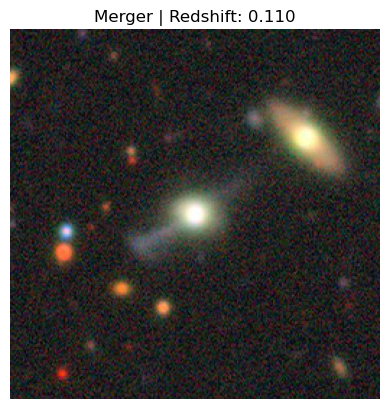

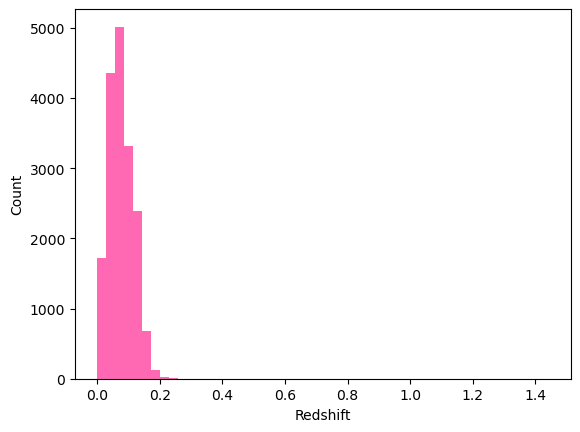

In [ ]:
import matplotlib.pyplot as plt

# Plot a random merger (for me to visulaise and check my data is loaded correctly)
idx = np.random.choice(len(merger_images))
plt.imshow(merger_images[idx])
plt.title(f"Merger | Redshift: {merger_redshifts[idx]:.3f}")
plt.axis('off')
plt.show()

# Plot redshift distribution
plt.hist(redshifts, color = 'hotpink', bins=50)
plt.xlabel("Redshift")
plt.ylabel("Count")
plt.show()

## 1b. Data Loading for Redshifts (issue outlined here)

In [ ]:
with h5py.File(full_path, 'r') as F:
    images = np.array(F['images'])
    labels = np.array(F['ans'])
    redshifts = np.array(F['redshift'])

In [ ]:
# Check original values BEFORE normalisation
print("Original dtype:", images.dtype)
print("Original min/max:", np.min(images), np.max(images))

Original dtype: uint8
Original min/max: 0 255


Here we need to convert to float to use as input into CNN, and normalise our data to [0,1].

In [ ]:
# Creates new contiguous array in one step
images = np.array(images, dtype='float32') / 255.0

In [ ]:
#merger_images = merger_images.astype('float32')
print("Merger images dtype:", merger_images.dtype)
print("Merger min/max:", np.min(merger_images), np.max(merger_images))

Merger images dtype: float32
Merger min/max: 0.0 255.0


In [ ]:
# Use the same method as before
merger_images = np.array(merger_images) / 255.0

In [ ]:
print("Merger images dtype:", merger_images.dtype)
print("Merger min/max:", np.min(merger_images), np.max(merger_images))

Merger images dtype: float32
Merger min/max: 0.0 1.0


Everything is ready for our image data. Now let's look at redshift data:

In [ ]:
print("Redshifts dtype:", redshifts.dtype)
print("Redshifts min/max:", np.min(redshifts), np.max(redshifts))
print("Redshifts mean/std:", np.mean(redshifts), np.std(redshifts))

Redshifts dtype: float64
Redshifts min/max: nan nan
Redshifts mean/std: nan nan


In [ ]:
# Count NaN:
num_nans = np.isnan(redshifts).sum()
print(f"Found {num_nans} NaN values in redshifts ({(num_nans/len(redshifts))*100:.1f}% of data)")

Found 92 NaN values in redshifts (0.5% of data)


Here I found 92 missing values in the redshift data. We want to remove these images/redshifts from our data.

In [ ]:
# Remove NaN values AND corresponding images/labels
valid_mask = ~np.isnan(redshifts)
redshifts_clean = redshifts[valid_mask]
images_clean = images[valid_mask]  # Align with cleaned redshifts
labels_clean = labels[valid_mask]  # If using labels

In [ ]:
print("Cleaned redshifts min/max:", np.min(redshifts_clean), np.max(redshifts_clean))
print("Cleaned redshifts mean/std:", np.mean(redshifts_clean), np.std(redshifts_clean))

Cleaned redshifts min/max: -0.0001244358 1.441647
Cleaned redshifts mean/std: 0.07750321706732066 0.04469131978755938


In [ ]:
with h5py.File(full_path, 'r') as F:
    print("HDF5 redshift dataset info:")
    print("Shape:", F['redshift'].shape)
    print("First 10 raw values:", F['redshift'][:10])  # Inspect actual stored values
    print("Dataset attributes:", dict(F['redshift'].attrs))  # Check for metadata

HDF5 redshift dataset info:
Shape: (17736,)
First 10 raw values: [0.08191886 0.11525209 0.10941774 0.10681571 0.12005576 0.11850124
 0.03771046 0.11946234 0.12666418 0.05846611]
Dataset attributes: {}


In [ ]:
with h5py.File(full_path, 'r') as F:
    print("All available datasets:", list(F.keys()))
    if 'specz' in F or 'z' in F:  # Common alternate names
        true_redshifts = np.array(F.get('specz', F.get('z')))

All available datasets: ['ans', 'dec', 'images', 'pxscale', 'ra', 'redshift']


## 2. Augmentation for Merger images

In [ ]:
from sklearn.model_selection import train_test_split
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Get the class indices (convert one-hot back to integers)
class_indices = np.argmax(labels, axis=1)  # Shape: (17736,), gives original labels

# Subset is 10% of total:
# Split into small subset (10%) for faster experimentation
images_full, images_small, labels_full, labels_small, redshifts_full, redshifts_small = train_test_split(
    images, labels, redshifts, test_size=0.1, stratify=class_indices, random_state=42
)

Images shape: (17736, 256, 256, 3)
Labels shape: (17736, 10)


In [ ]:
# Print sizes
print(f"Total images: {images.shape[0]}")
print(f"Subset size (10%): {images_small.shape[0]}")
print(f"Remaining full set: {images_full.shape[0]}")

Total images: 17736
Subset size (10%): 1774
Remaining full set: 15962


In [ ]:
# Check label shape and get class indices
if labels_small.ndim == 2:
    class_indices_small = np.argmax(labels_small, axis=1)
else:
    class_indices_small = labels_small

# Clean out NaNs from redshift in the small subset
valid_mask = ~np.isnan(redshifts_small)
images_small = images_small[valid_mask]
labels_small = labels_small[valid_mask]
redshifts_small = redshifts_small[valid_mask]

In [ ]:
np.savez('subset_cleandata.npz', images=images_small, labels=labels_small, redshifts=redshifts_small)

# To run from here on:
data = np.load('subset_cleandata.npz')
images_small = data['images']
labels_small = data['labels']
redshifts_small = data['redshifts']


In [ ]:
# To run from here on:
data = np.load('subset_cleandata.npz')
images_small = data['images']
labels_small = data['labels']
redshifts_small = data['redshifts']

Here I cleaned after as didn't want to run full data again - if I had done this prior then I would not need to do this

In [ ]:
subset_size = images_small.shape[0]
subset_merg = (np.argmax(labels_small, axis=1) == 0).sum()
# Print size post-cleaning:
print("Cleaned subset size (after removing NaNs):", subset_size)
print("Number of merging galaxies in cleaned subset: ", subset_merg)
print(f"Percentage of merging galaxies in cleaned subset: {(subset_merg)/(subset_size) * 100} %")

Cleaned subset size (after removing NaNs): 1767
Number of merging galaxies in cleaned subset:  106
Percentage of merging galaxies in cleaned subset: 5.998868138087153 %


### Data Notes
- The dataset's `'redshift'` values range: ~0.03–1.44
- RA/Dec coordinates are retained for potential cross-matching in future work.

## 3. Data Resampling (Oversample for Mergers)

Mergers are less than 6% of small subset- we want to avoid our model favouring the majority class.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
"""
Label input looks like [1, 0, 0, 0, 0, 0, 0, 0, 0, 0] for merger (one-hot) (class 0 is merger)
Flatten image data for logistic regression as can only take 2D not image data
# (N, 256*256*3) to (N,)
assign binary labels 1 = merger, 0 = non
use imblearn over sampler
"""
# Preprocess the labels
X = images_small.reshape(images_small.shape[0], -1)
y = np.argmax(labels_small, axis=1)

# Binary filter: 1 = merger, 0 = non-merger
y_binary = (y == 0).astype(int)
X_binary = X

X_train, X_test, y_train, y_test = train_test_split(
    X_binary, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)
# Apply oversampling to make mergers 25% of total
ros = RandomOverSampler(sampling_strategy=0.25, random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_binary, y_binary)

ros = RandomOverSampler(sampling_strategy=0.25, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Count after oversampling
print("Before oversampling:", np.bincount(y_binary))
print("After oversampling:", np.bincount(y_resampled))

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.valida

Before oversampling: [1661  106]
After oversampling: [1661  415]


## 4. Baseline Models (Logistic Regression + Linear Regression)

Logistic Regression for Classification:

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import cosine_similarity

# Flatten images
X = images_small.reshape(images_small.shape[0], -1)
y = np.argmax(labels_small, axis=1)

# Binary labels: 1 = merger, 0 = non-merger
y_binary = (y == 0).astype(int)

# Train/test split ( BEFORE oversampling)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, stratify=y_binary, random_state=42
)

# Apply oversampling only to training set
ros = RandomOverSampler(sampling_strategy=0.40, random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Check class balance
print("Before oversampling (train):", np.bincount(y_train))
print("After oversampling (train):", np.bincount(y_train_resampled))

# Train baseline logistic regression
clf = LogisticRegression(max_iter=100)
clf.fit(X_train_resampled, y_train_resampled)

# Predict on untouched test set
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Check for duplicates — should be < 1.0
dup_check = cosine_similarity(X_test, X_train_resampled)
print("Max similarity between test and train samples:", dup_check.max())


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.


Before oversampling (train): [1328   85]
After oversampling (train): [1328  531]
Accuracy: 0.943502824858757
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       333
           1       0.60      0.14      0.23        21

    accuracy                           0.94       354
   macro avg       0.77      0.57      0.60       354
weighted avg       0.93      0.94      0.93       354

Confusion Matrix:
 [[331   2]
 [ 18   3]]
Max similarity between test and train samples: 0.9643862115785181


Linear Regression for Redshift Estimates

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Get merger indices
y_full = np.argmax(labels_small, axis=1)
merger_mask = y_full == 0

# Filter images and redshifts
X_mergers = images_small[merger_mask].reshape(-1, 256*256*3)
y_redshift = redshifts_small[merger_mask]

# Remove NaNs (should already be done — but just in case)
valid_mask = ~np.isnan(y_redshift)
X_mergers = X_mergers[valid_mask]
y_redshift = y_redshift[valid_mask]

# Train/test split
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_mergers, y_redshift, test_size=0.2, random_state=42
)

# Linear regression
reg = LinearRegression()
reg.fit(X_train_r, y_train_r)

# Predict and evaluate
y_pred_r = reg.predict(X_test_r)

print("MSE:", mean_squared_error(y_test_r, y_pred_r))
print("R^2:", r2_score(y_test_r, y_pred_r))
std_redshift_test = np.std(y_test_r)
tolerance = std_redshift_test
accuracy_within_std = np.mean(np.abs(y_pred_r - y_test_r) <= tolerance)
print(f"Accuracy within ±1 std (test set): {accuracy_within_std:.3f}")



MSE: 0.0009791719076048368
R^2: 0.36528747084389723
Accuracy within ±1 std (test set): 0.818


## 5. CNN Implementation (Dual-Output Model)

### i) Create Final Subset

Creating training dataset of 50% mergers 50% non-mergers, with valid redshifts.

In [ ]:
import h5py
import numpy as np

full_path = '/content/drive/MyDrive/Galaxy10_DECals.h5'

# Open the file
with h5py.File(full_path, 'r') as F:
    images = np.array(F['images'])  # Shape: (17736, 256, 256, 3)
    labels = np.array(F['ans'])      # Shape: (17736,)
    redshifts = np.array(F['redshift'])  # Shape: (17736,)

print(f"Loaded full dataset: {images.shape[0]} images")



Loaded full dataset: 17736 images


In [ ]:
# Filter out NaN redshifts
valid_redshift_mask = ~np.isnan(redshifts)

images = images[valid_redshift_mask]
labels = labels[valid_redshift_mask]
redshifts = redshifts[valid_redshift_mask]


In [ ]:
# Using too much RAM to normalise before
merger_mask = labels == 0
non_merger_mask = labels != 0

merger_images = images[merger_mask]
merger_redshifts = redshifts[merger_mask]

non_merger_images = images[non_merger_mask]
non_merger_redshifts = redshifts[non_merger_mask]
# Use all available mergers
merger_indices = np.random.choice(len(merger_images), 1073, replace=False)

# Randomly select same number of non-mergers
non_merger_indices = np.random.choice(len(non_merger_images), 1073, replace=False)

# Create the new
largesubset_images = np.concatenate((merger_images[merger_indices], non_merger_images[non_merger_indices]))
largesubset_redshifts = np.concatenate((merger_redshifts[merger_indices], non_merger_redshifts[non_merger_indices]))
largesubset_labels = np.concatenate((np.zeros(1073), np.ones(1073)))

print(f"New subset created with shape: {largesubset_images.shape}")


New subset created with shape: (2146, 256, 256, 3)


In [ ]:
# Normalise
largesubset_images = largesubset_images.astype('float32') / 255.0

# Save compressed
np.savez_compressed('norm_merger_balanced_large_subset_data.npz',
                    images=largesubset_images,
                    labels=largesubset_labels,
                    redshifts=largesubset_redshifts)

print("Saved new balanced subset: norm_merger_balanced_large_subset_data.npz")

Saved new balanced subset: norm_merger_balanced_large_subset_data.npz


In [ ]:
# Random selection with seed for reproducibility
np.random.seed(42)
merger_indices = np.random.choice(len(merger_images), 800, replace=False)
non_merger_indices = np.random.choice(len(non_merger_images), 800, replace=False)

subset_images = np.concatenate((merger_images[merger_indices], non_merger_images[non_merger_indices]))
subset_redshifts = np.concatenate((merger_redshifts[merger_indices], non_merger_redshifts[non_merger_indices]))
subset_labels = np.concatenate((np.zeros(800), np.ones(800)))  # 0 for merger, 1 for non-merger


In [ ]:
np.savez_compressed('Final Project/norm_merger_subset_data.npz',
                    images=subset_images,
                    labels=subset_labels,
                    redshifts=subset_redshifts)
print("Subset saved!")


Subset saved!


In [ ]:
# Load subset
subset_path = '/content/drive/MyDrive/norm_merger_balanced_large_subset_data.npz'

data = np.load(subset_path)
images = data['images']
labels = data['labels']     # 0 = merger, 1 = non-merger
redshifts = data['redshifts']

print(f"Loaded subset: {images.shape[0]} images")



Loaded subset: 2146 images


### ii) Format Merger Dataset

In [ ]:
from torch.utils.data import Dataset


class MergerDataset(Dataset):
    def __init__(self, images, labels, redshifts, transform=None):
        self.images = images
        self.labels = labels
        self.redshifts = redshifts
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        redshift = self.redshifts[idx]

        if self.transform:
            image = self.transform(image)

        # Return as tensor
        return {
            'image': torch.tensor(image).permute(2, 0, 1).float(),  # convert to pytorch to input correctly [H, W, C] to[C, H, W]
            'label': torch.tensor(label).long(),                    # For classification (merging vs non-merging)
            'redshift': torch.tensor(redshift).float()              # For regression (for redshifts)
        }


In [ ]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels, train_redshifts, val_redshifts = train_test_split(
    images, labels, redshifts, test_size=0.2, random_state=42)

In [ ]:
from torch.utils.data import DataLoader

train_dataset = MergerDataset(train_images, train_labels, train_redshifts)
val_dataset = MergerDataset(val_images, val_labels, val_redshifts)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

### Check these are working correctly:

In [ ]:
data = np.load('Final Project/norm_merger_largesubset_data.npz')
images = data['images']           # Shape: (1600, 256, 256, 3)
labels = data['labels']           # Shape: (1600,)
redshifts = data['redshifts']     # Shape: (1600,)

FileNotFoundError: [Errno 2] No such file or directory: 'Final Project/norm_merger_large_subset_data.npz'

In [ ]:
# Inspect one batch
for batch in train_loader:
    print("Image batch shape:", batch['image'].shape)      # Expect: (4, 3, 256, 256)
    print("Label batch:", batch['label'])                  # Expect: tensor of shape (4,)
    print("Redshift batch:", batch['redshift'])            # Expect: tensor of shape (4,)
    break  # Only check the first batch

NameError: name 'train_loader' is not defined

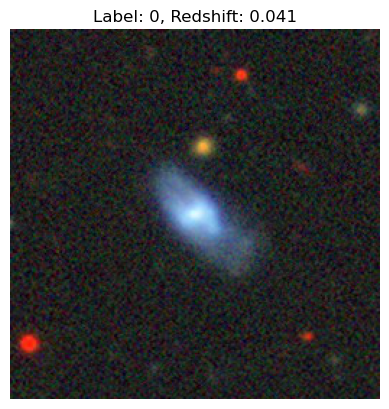

In [ ]:
sample_image = batch['image'][3].permute(1, 2, 0).numpy()  # Back to (H, W, C)
plt.imshow(sample_image)
plt.title(f"Label: {batch['label'][3].item()}, Redshift: {batch['redshift'][3].item():.3f}")
plt.axis('off')
plt.show()


### iii) Define CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DualHeadCNN(nn.Module):
    def __init__(self):
        super(DualHeadCNN, self).__init__()

        """
        CNN part that extracts features from galaxy images.
        1st block: Takes in 3-channel RGB images, applies 16 filters, outputs  (16, 256, 256)
        ReLU activation to introduce non-linearity
        Downsamples by a factor of 2: (16, 256, 256) to (16, 128, 128) (reduces size by looking at max value (pooling)

        2nd block:
        Same as above by different values

        3rd block:
        (64, 32, 32) after 3 rounds of downsampling,

        - Flatten to single vector to then map onto layer w features
        - Fully connected layer takes all flattened features from layers and transforms them into a shared representation


        Forward pass:
        - put through features, our vector and shared layer
        -


        """
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 3, 256, 256 to 32, 256, 256
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )


        # 3D output (64 × 32 × 32) flattened to single vector: 64 * 32 * 32 = 65536
        self.flatten = nn.Flatten()

        # Shared dense representation
        self.shared_fc = nn.Sequential(
            nn.Linear(128 * 32 * 32, 256), # maps vector to dense layer with 256 features
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )



        # Classification head
        self.classifier = nn.Linear(128, 2)  # binary class

        # Regression head (redshift)
        self.regressor = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.shared_fc(x)

        class_out = self.classifier(x)                # shape: (batch_size, 2)
        redshift_out = self.regressor(x).squeeze(1)   # shape: (batch_size,)

        return class_out, redshift_out


In [ ]:
# Loss Function for both:

def dual_loss_fn(class_preds, redshift_preds, true_labels, true_redshifts, alpha=10.0, beta=1.0):
    classification_loss = nn.CrossEntropyLoss()(class_preds, true_labels)

    merger_mask = (true_labels == 0)
    if merger_mask.sum() > 0:
        regression_loss = nn.MSELoss()(redshift_preds[merger_mask], true_redshifts[merger_mask])
    else:
        regression_loss = torch.tensor(0.0, device=true_labels.device)

    total_loss = alpha * classification_loss + beta * regression_loss
    return total_loss, classification_loss, regression_loss



Initialise and check we are on GPU (less runtime)

### One epoch replaced by validation and train function

In [ ]:
def train_one_epoch(model, train_loader, optimiser):
    model.train()
    total_loss = 0.0
    total_class_loss = 0.0
    total_reg_loss = 0.0
    correct = 0
    total = 0

    for batch in train_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)
        redshifts = batch['redshift'].to(device)

        optimiser.zero_grad()

        # Forward pass
        class_out, redshift_out = model(images)

        # Compute combined loss
        #loss, class_loss, reg_loss = dual_loss_fn(class_out, redshift_out, labels, redshifts)
        loss, class_loss, reg_loss = dual_loss_fn(class_out, redshift_out, labels, redshifts, alpha=10.0, beta=1.0)


        loss.backward()
        optimiser.step()

        # Track loss
        total_loss += loss.item()
        total_class_loss += class_loss
        total_reg_loss += reg_loss

        # Compute accuracy
        preds = torch.argmax(class_out, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = correct / total

    print(f"Train Loss: {avg_loss:.4f} | Classification Loss: {total_class_loss:.4f} | Regression Loss: {total_reg_loss:.4f}")
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

    train_acc_history.append(accuracy * 100)
    class_loss_history.append(total_class_loss / len(train_loader))
    reg_loss_history.append(total_reg_loss / len(train_loader))



In [ ]:
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_one_epoch(model, train_loader, optimiser)


Epoch 1/3
Train Loss: 7.1428 | Classification Loss: 14.2555 | Regression Loss: 0.3017
Classification Accuracy: 48.98%
Epoch 2/3
Train Loss: 6.8993 | Classification Loss: 13.7929 | Regression Loss: 0.0575
Classification Accuracy: 52.42%
Epoch 3/3
Train Loss: 6.4746 | Classification Loss: 12.9418 | Regression Loss: 0.0735
Classification Accuracy: 63.98%


In [ ]:
train_acc_history = []
class_loss_history = []
reg_loss_history = []


In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_one_epoch(model, train_loader, optimiser)


Epoch 1/50
Train Loss: 5.5804 | Classification Loss: 11.1572 | Regression Loss: 0.0353
Classification Accuracy: 71.95%
Epoch 2/50
Train Loss: 4.8594 | Classification Loss: 9.7130 | Regression Loss: 0.0578
Classification Accuracy: 77.03%
Epoch 3/50
Train Loss: 3.7323 | Classification Loss: 7.4587 | Regression Loss: 0.0581
Classification Accuracy: 83.98%
Epoch 4/50
Train Loss: 2.6221 | Classification Loss: 5.2382 | Regression Loss: 0.0593
Classification Accuracy: 89.45%
Epoch 5/50
Train Loss: 1.7747 | Classification Loss: 3.5403 | Regression Loss: 0.0909
Classification Accuracy: 93.52%
Epoch 6/50
Train Loss: 1.0750 | Classification Loss: 2.1439 | Regression Loss: 0.0616
Classification Accuracy: 95.62%
Epoch 7/50
Train Loss: 0.8277 | Classification Loss: 1.6470 | Regression Loss: 0.0837
Classification Accuracy: 97.27%
Epoch 8/50
Train Loss: 0.4107 | Classification Loss: 0.8150 | Regression Loss: 0.0639
Classification Accuracy: 99.06%
Epoch 9/50
Train Loss: 0.1894 | Classification Loss: 0.

KeyboardInterrupt: 

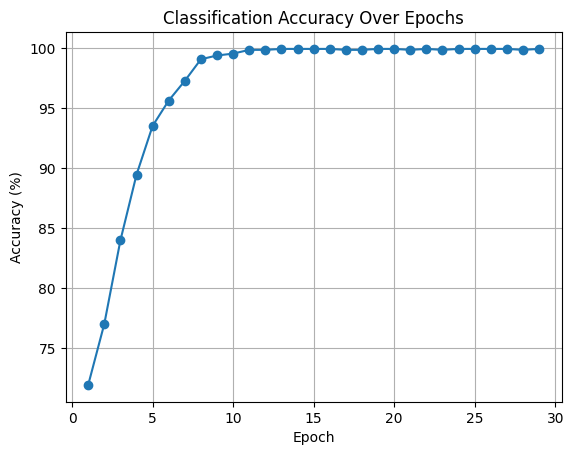

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

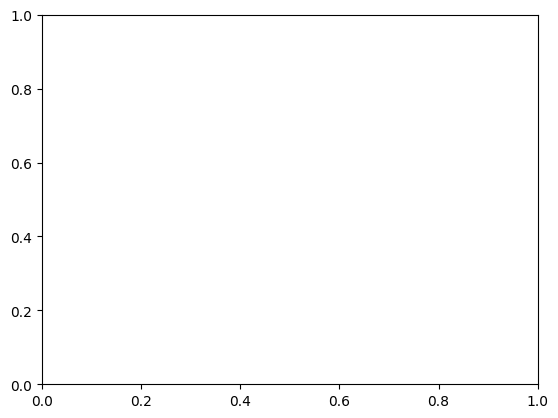

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_acc_history) + 1))

# Plot Accuracy
plt.figure()
plt.plot(epochs, train_acc_history, marker='o')
plt.title("Classification Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.show()

# Plot Losses
plt.figure()
plt.plot(epochs, class_loss_history, marker='o', label='Classification Loss')
plt.plot(epochs, reg_loss_history, marker='s', label='Regression Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import numpy as np

np_labels = labels.numpy() if hasattr(labels, 'numpy') else np.array(labels)

print("Total samples:", len(np_labels))
print("Mergers (label=0):", np.sum(np_labels == 0))
print("Non-mergers (label=1):", np.sum(np_labels == 1))



Total samples: 64
Mergers (label=0): 39
Non-mergers (label=1): 25


In [ ]:
model.eval()
with torch.no_grad():
    batch = next(iter(train_loader))
    images = batch['image'].to(device)
    labels = batch['label'].to(device)

    class_out, _ = model(images)  # Ignore redshift for now

    print("Raw class logits (first 5):")
    print(class_out[:5])

    probs = torch.softmax(class_out, dim=1)
    print("Softmax probabilities:")
    print(probs[:5])


Raw class logits (first 5):
tensor([[ 0.0478, -0.0115],
        [ 0.0458, -0.0114],
        [ 0.0470, -0.0115],
        [ 0.0472, -0.0116],
        [ 0.0479, -0.0107]])
Softmax probabilities:
tensor([[0.5148, 0.4852],
        [0.5143, 0.4857],
        [0.5146, 0.4854],
        [0.5147, 0.4853],
        [0.5147, 0.4853]])


In [ ]:
def train_and_validate(model, train_loader, val_loader, optimiser, num_epochs=40, alpha=10.0, beta=1.0):
    train_acc_history = []
    val_acc_history = []
    train_class_loss_history = []
    val_class_loss_history = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_correct, total_train = 0, 0, 0

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            redshifts = batch['redshift'].to(device)

            class_out, redshift_out = model(images)

            loss, class_loss, reg_loss = dual_loss_fn(class_out, redshift_out, labels, redshifts, alpha, beta)

            optimiser.zero_grad()
            loss.backward()
            optimiser.step()

            total_train_loss += loss.item()
            preds = class_out.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = total_correct / total_train
        train_acc_history.append(train_acc * 100)
        train_class_loss_history.append(class_loss.item())

        # Validation
        model.eval()
        total_val_loss, total_val_correct, total_val = 0, 0, 0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                redshifts = batch['redshift'].to(device)

                class_out, redshift_out = model(images)
                loss, class_loss, reg_loss = dual_loss_fn(class_out, redshift_out, labels, redshifts, alpha, beta)

                total_val_loss += loss.item()
                preds = class_out.argmax(dim=1)
                total_val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = total_val_correct / total_val
        val_acc_history.append(val_acc * 100)
        val_class_loss_history.append(class_loss.item())

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), "best_dualhead_model.pth")
            print(f"Saved new best model at epoch {epoch+1} with val accuracy {val_acc*100:.2f}%")

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

    return train_acc_history, val_acc_history, train_class_loss_history, val_class_loss_history


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = DualHeadCNN()
model = model.to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

train_acc, val_acc, train_loss, val_loss = train_and_validate(
    model, train_loader, val_loader, optimiser, num_epochs=40, alpha=10.0, beta=1.0)


Using device: cuda
Saved new best model at epoch 1 with val accuracy 46.56%
Epoch 1/40 | Train Acc: 52.58% | Val Acc: 46.56%
Saved new best model at epoch 2 with val accuracy 60.94%
Epoch 2/40 | Train Acc: 52.27% | Val Acc: 60.94%
Saved new best model at epoch 3 with val accuracy 61.56%
Epoch 3/40 | Train Acc: 62.66% | Val Acc: 61.56%
Epoch 4/40 | Train Acc: 68.67% | Val Acc: 59.69%
Epoch 5/40 | Train Acc: 70.08% | Val Acc: 60.31%
Epoch 6/40 | Train Acc: 77.19% | Val Acc: 59.69%
Epoch 7/40 | Train Acc: 84.77% | Val Acc: 59.38%
Epoch 8/40 | Train Acc: 93.20% | Val Acc: 57.50%
Epoch 9/40 | Train Acc: 97.66% | Val Acc: 59.06%
Epoch 10/40 | Train Acc: 98.44% | Val Acc: 58.13%
Epoch 11/40 | Train Acc: 97.81% | Val Acc: 60.00%
Epoch 12/40 | Train Acc: 99.14% | Val Acc: 56.56%
Epoch 13/40 | Train Acc: 99.77% | Val Acc: 57.19%
Epoch 14/40 | Train Acc: 99.92% | Val Acc: 56.88%
Epoch 15/40 | Train Acc: 98.98% | Val Acc: 55.94%
Epoch 16/40 | Train Acc: 99.14% | Val Acc: 57.81%
Epoch 17/40 | Train

Plots of Performance:

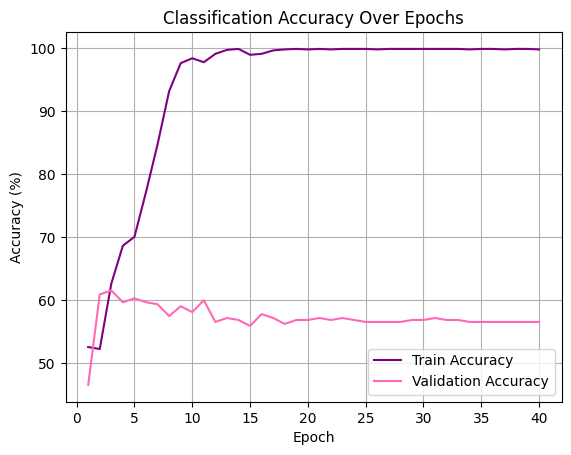

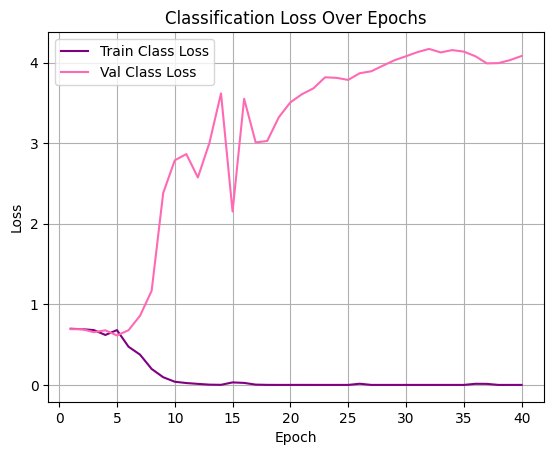

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_acc) + 1))

# Accuracy
plt.figure()
plt.plot(epochs, train_acc, color = 'purple', label='Train Accuracy')
plt.plot(epochs, val_acc, color = 'hotpink', label='Validation Accuracy')
plt.title("Classification Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(epochs, train_loss, color = 'purple', label='Train Class Loss')
plt.plot(epochs, val_loss, color = 'hotpink', label='Val Class Loss')
plt.title("Classification Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


Suspect overfitting (train accuracy increases - validation stuck)

In [ ]:
# Reinitialise model
best_model = DualHeadCNN().to(device)

# Load best saved weights
best_model.load_state_dict(torch.load("best_dualhead_model.pth"))
best_model.eval()


DualHeadCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (shared_fc): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        class_out, _ = best_model(images)
        preds = class_out.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Flatten lists
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)


              precision    recall  f1-score   support

     Merging       0.68      0.53      0.60       171
 Non-Merging       0.57      0.71      0.63       149

    accuracy                           0.62       320
   macro avg       0.62      0.62      0.61       320
weighted avg       0.63      0.62      0.61       320



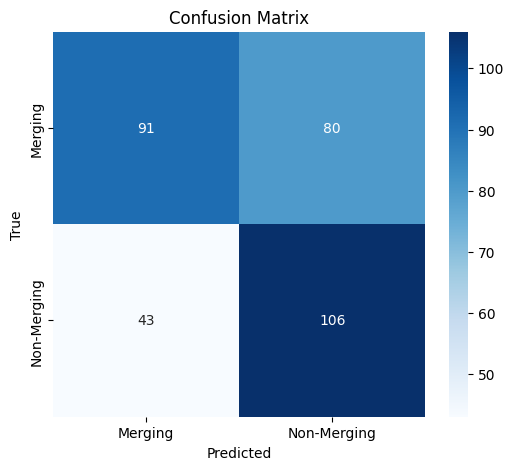

In [ ]:
# Classification Report
print(classification_report(all_labels, all_preds, target_names=["Merging", "Non-Merging"]))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Merging", "Non-Merging"], yticklabels=["Merging", "Non-Merging"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


This is better than baseline for mergers - but I want to increase my accuracy further

# Further developing CNN

### Augmentation:

In [ ]:
class MergerDataset(Dataset):
    def __init__(self, images, labels, redshifts, transform=None):
        self.images = images
        self.labels = labels
        self.redshifts = redshifts
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image = self.images[idx]
      label = self.labels[idx]
      redshift = self.redshifts[idx]

      #  Convert NumPy to Torch tensor
      image = torch.tensor(image).permute(2, 0, 1).float()

      # 2. Apply transformation
      if self.transform:
          image = self.transform(image)

      return {
          'image': image,
          'label': torch.tensor(label).long(),
          'redshift': torch.tensor(redshift).float()
      }

### Add dropout to avoid overfitting

In [ ]:
class DualHeadCNN(nn.Module):
    def __init__(self):
        super(DualHeadCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten()

        self.shared_fc = nn.Sequential(
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(p=0.3)  # Dropout

        self.classifier = nn.Linear(128, 2)
        self.regressor = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        x = self.dropout(x)  #Apply dropout

        class_out = self.classifier(x)
        redshift_out = self.regressor(x).squeeze(1)

        return class_out, redshift_out


In [ ]:
# Augment images (add random flips/rotations etc)
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x),  # No change for validation
])


In [ ]:
# Create training and validation datasets with transforms
train_dataset = MergerDataset(train_images, train_labels, train_redshifts, transform=train_transform)
val_dataset = MergerDataset(val_images, val_labels, val_redshifts, transform=val_transform)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


### Train again and see if this works:

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
model = DualHeadCNN().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
train_acc, val_acc, train_loss, val_loss = train_and_validate(
    model, train_loader, val_loader, optimiser, num_epochs=50, alpha=10.0, beta=1.0
)


Saved new best model at epoch 1 with val accuracy 60.70%
Epoch 1/50 | Train Acc: 52.45% | Val Acc: 60.70%
Saved new best model at epoch 2 with val accuracy 63.72%
Epoch 2/50 | Train Acc: 63.29% | Val Acc: 63.72%
Saved new best model at epoch 3 with val accuracy 66.28%
Epoch 3/50 | Train Acc: 66.67% | Val Acc: 66.28%
Saved new best model at epoch 4 with val accuracy 67.44%
Epoch 4/50 | Train Acc: 69.64% | Val Acc: 67.44%
Epoch 5/50 | Train Acc: 77.97% | Val Acc: 63.26%
Epoch 6/50 | Train Acc: 83.86% | Val Acc: 62.79%
Epoch 7/50 | Train Acc: 90.21% | Val Acc: 63.26%
Epoch 8/50 | Train Acc: 95.34% | Val Acc: 61.86%
Epoch 9/50 | Train Acc: 97.44% | Val Acc: 60.93%
Epoch 10/50 | Train Acc: 98.72% | Val Acc: 63.26%
Epoch 11/50 | Train Acc: 99.77% | Val Acc: 62.33%
Epoch 12/50 | Train Acc: 99.88% | Val Acc: 60.47%
Epoch 13/50 | Train Acc: 99.77% | Val Acc: 63.26%
Epoch 14/50 | Train Acc: 99.88% | Val Acc: 61.63%
Epoch 15/50 | Train Acc: 99.83% | Val Acc: 61.86%
Epoch 16/50 | Train Acc: 99.88%

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

epochs = list(range(1, len(train_acc) + 1))

# Accuracy
plt.figure()
plt.plot(epochs, train_acc, color = 'purple', label="Train Accuracy")
plt.plot(epochs, val_acc, color = 'hotpink', label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure()
plt.plot(epochs, train_loss, color = 'purple', label="Train Class Loss")
plt.plot(epochs, val_loss, color = 'hotpink', label="Validation Class Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classification Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'train_acc' is not defined

In [ ]:
# Reinitialise
best_model = DualHeadCNN().to(device)

# Load the best saved weights
best_model.load_state_dict(torch.load("best_dualhead_model.pth"))
best_model.eval()


DualHeadCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (shared_fc): Sequential(
    (0): Linear(in_features=131072, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (regressor): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        class_out, _ = best_model(images)
        preds = class_out.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

# Flatten lists
all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)


NameError: name 'best_model' is not defined

              precision    recall  f1-score   support

     Merging       0.68      0.77      0.73       171
 Non-Merging       0.69      0.59      0.64       149

    accuracy                           0.69       320
   macro avg       0.69      0.68      0.68       320
weighted avg       0.69      0.69      0.68       320



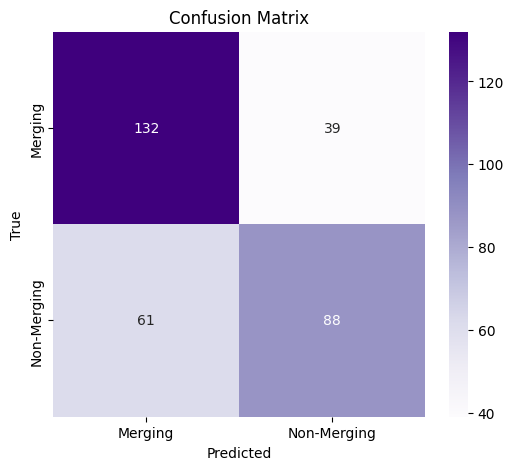

In [ ]:
# Classification Report
print(classification_report(all_labels, all_preds, target_names=["Merging", "Non-Merging"]))

# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Merging", "Non-Merging"], yticklabels=["Merging", "Non-Merging"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Plot true redshift vs predicted redshift
plt.figure(figsize=(6,6))
plt.scatter(true_redshifts, pred_redshifts, alpha=0.5)
plt.plot([true_redshifts.min(), true_redshifts.max()],
         [true_redshifts.min(), true_redshifts.max()],
         'r--', label='Perfect Prediction')

plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Prediction Scatter Plot (Experiment 3)')
plt.legend()
plt.grid(True)
plt.show()# Plot true redshift vs predicted redshift
plt.figure(figsize=(6,6))
plt.scatter(true_redshifts, pred_redshifts, alpha=0.5)
plt.plot([true_redshifts.min(), true_redshifts.max()],
         [true_redshifts.min(), true_redshifts.max()],
         'r--', label='Perfect Prediction')

plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Prediction Scatter Plot (Experiment 3)')
plt.legend()
plt.grid(True)
plt.show()

Here, i see that validation loss / accuracy plateaus - i have done what i can with this model.

# Train and test on Full Dataset

In [ ]:
# Load subset
subset_path = '/content/drive/MyDrive/norm_merger_balanced_large_subset_data.npz'

data = np.load(subset_path)
images = data['images']
labels = data['labels']     # 0 = merger, 1 = non-merger
redshifts = data['redshifts']

print(f"Loaded subset: {images.shape[0]} images")
images = images.cpu().numpy()


Loaded subset: 2146 images


In [ ]:
# Load from .npz file
subset_path = '/content/drive/MyDrive/norm_merger_balanced_large_subset_data.npz'

data = np.load(subset_path)
images = data['images']  # Should already be NumPy arrays here
labels = data['labels']
redshifts = data['redshifts']

print(f"Loaded subset: {images.shape[0]} images")

# images = images.cpu().numpy()

# Convert RGB to Greyscale
def rgb2gray(rgb_images):
    return np.dot(rgb_images[...,:3], [0.2989, 0.5870, 0.1140])

# Apply conversion
images_gray = rgb2gray(images)  # Shape now (N, 256, 256)

# Add channel dimension back
images_gray = images_gray[..., np.newaxis]  # Now (N, 256, 256, 1)

print(f"Grayscale images shape: {images_gray.shape}")

# Save greyscale version
np.savez_compressed('/content/drive/MyDrive/norm_merger_balanced_large_subset_grayscale.npz',
                    images=images_gray,
                    labels=labels,
                    redshifts=redshifts)

print("Saved new greyscale dataset!")



Loaded subset: 2146 images
Grayscale images shape: (2146, 256, 256, 1)
Saved new grayscale dataset!


In [ ]:
print(f"Min pixel value: {images.min()}")
print(f"Max pixel value: {images.max()}")


Min pixel value: 0.0
Max pixel value: 1.0


In [ ]:
data = np.load('/content/drive/MyDrive/norm_merger_balanced_large_subset_grayscale.npz')
images = data['images']
labels = data['labels']
redshifts = data['redshifts']

print(f"Loaded grayscale subset: {images.shape}")


Loaded grayscale subset: (2146, 256, 256, 1)


In [ ]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels, train_redshifts, val_redshifts = train_test_split(
    images, labels, redshifts, test_size=0.2, random_state=42)

print(f"Train set: {train_images.shape[0]} images")
print(f"Validation set: {val_images.shape[0]} images")


Train set: 1716 images
Validation set: 430 images


In [ ]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x)
])

In [ ]:
from torch.utils.data import Dataset
import torch

class MergerDataset(Dataset):
    def __init__(self, images, labels, redshifts, transform=None):
        self.images = images
        self.labels = labels
        self.redshifts = redshifts
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        redshift = self.redshifts[idx]


        image = torch.tensor(image).permute(2, 0, 1).float()  # [C, H, W]


        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'label': torch.tensor(label).long(),
            'redshift': torch.tensor(redshift).float()
        }


In [ ]:
class DualHeadCNN(nn.Module):
    def __init__(self):
        super(DualHeadCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )


        self.flatten = nn.Flatten()

        self.shared_fc = nn.Sequential(
            nn.Linear(128 * 32 * 32, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU()
        )

        self.dropout = nn.Dropout(p=0.3)  # Dropout

        self.classifier = nn.Linear(128, 2)
        self.regressor = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.shared_fc(x)
        x = self.dropout(x)  #Apply dropout

        class_out = self.classifier(x)
        redshift_out = self.regressor(x).squeeze(1)

        return class_out, redshift_out

In [ ]:
# Loss Function for both:

def dual_loss_fn(class_preds, redshift_preds, true_labels, true_redshifts, alpha=10.0, beta=1.0):
    classification_loss = nn.CrossEntropyLoss()(class_preds, true_labels)

    merger_mask = (true_labels == 0)
    if merger_mask.sum() > 0:
        regression_loss = nn.MSELoss()(redshift_preds[merger_mask], true_redshifts[merger_mask])
    else:
        regression_loss = torch.tensor(0.0, device=true_labels.device)

    total_loss = alpha * classification_loss + beta * regression_loss
    return total_loss, classification_loss, regression_loss


In [ ]:
from torch.utils.data import DataLoader

train_dataset = MergerDataset(train_images, train_labels, train_redshifts, transform=train_transform)
val_dataset = MergerDataset(val_images, val_labels, val_redshifts, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
batch = next(iter(train_loader))
print(f"Train batch image shape: {batch['image'].shape}")


Train batch image shape: torch.Size([64, 1, 256, 256])


In [ ]:
train_dataset = MergerDataset(train_images, train_labels, train_redshifts)
val_dataset = MergerDataset(val_images, val_labels, val_redshifts)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DualHeadCNN().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
def train_and_validate_with_early_stopping(model, train_loader, val_loader, optimiser,
                                           num_epochs=100, alpha = 8, beta = 4, patience = 15):
    train_acc_history = []
    val_acc_history = []
    train_class_loss_history = []
    val_class_loss_history = []
    train_reg_loss_history = []
    val_reg_loss_history = []

    best_val_acc = 0.0
    epochs_no_improve = 0
    best_epoch = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss, total_correct, total_train = 0, 0, 0
        total_train_class_loss = 0.0
        total_train_reg_loss = 0.0

        for batch in train_loader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            redshifts = batch['redshift'].to(device)

            optimiser.zero_grad()

            class_out, redshift_out = model(images)
            loss, class_loss, reg_loss = dual_loss_fn(class_out, redshift_out, labels, redshifts, alpha, beta)

            loss.backward()
            optimiser.step()

            total_train_loss += loss.item()
            total_train_class_loss += class_loss.item()
            total_train_reg_loss += reg_loss.item()

            preds = class_out.argmax(dim=1)
            total_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = total_correct / total_train
        train_acc_history.append(train_acc * 100)
        train_class_loss_history.append(total_train_class_loss / len(train_loader))
        train_reg_loss_history.append(total_train_reg_loss / len(train_loader))

        # Validation
        model.eval()
        total_val_loss, total_val_correct, total_val = 0, 0, 0
        total_val_class_loss = 0.0
        total_val_reg_loss = 0.0

        with torch.no_grad():
            for batch in val_loader:
                images = batch['image'].to(device)
                labels = batch['label'].to(device)
                redshifts = batch['redshift'].to(device)

                class_out, redshift_out = model(images)
                loss, class_loss, reg_loss = dual_loss_fn(class_out, redshift_out, labels, redshifts, alpha, beta)

                total_val_loss += loss.item()
                total_val_class_loss += class_loss.item()
                total_val_reg_loss += reg_loss.item()

                preds = class_out.argmax(dim=1)
                total_val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = total_val_correct / total_val
        val_acc_history.append(val_acc * 100)
        val_class_loss_history.append(total_val_class_loss / len(val_loader))
        val_reg_loss_history.append(total_val_reg_loss / len(val_loader))

        # Check if new best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_dualhead_model_exp4.pth")
            print(f"Saved new best model at epoch {epoch+1} with val accuracy {val_acc*100:.2f}%")
        else:
            epochs_no_improve += 1

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

        # Early stopping
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs (no improvement in {patience} epochs).")
            break

    return train_acc_history, val_acc_history, train_class_loss_history, val_class_loss_history, train_reg_loss_history, val_reg_loss_history


### Model v1

In [ ]:
train_acc, val_acc, train_class_loss, val_class_loss, train_reg_loss, val_reg_loss = train_and_validate_with_early_stopping(
    model, train_loader, val_loader, optimiser,
    num_epochs=100, alpha=10.0, beta=1.0, patience=10
)



Saved new best model at epoch 1 with val accuracy 54.19%
Epoch 1/100 | Train Acc: 49.07% | Val Acc: 54.19%
Epoch 2/100 | Train Acc: 57.40% | Val Acc: 52.09%
Saved new best model at epoch 3 with val accuracy 55.58%
Epoch 3/100 | Train Acc: 59.03% | Val Acc: 55.58%
Saved new best model at epoch 4 with val accuracy 55.81%
Epoch 4/100 | Train Acc: 65.68% | Val Acc: 55.81%
Saved new best model at epoch 5 with val accuracy 59.07%
Epoch 5/100 | Train Acc: 68.41% | Val Acc: 59.07%
Epoch 6/100 | Train Acc: 73.43% | Val Acc: 58.84%
Epoch 7/100 | Train Acc: 79.08% | Val Acc: 57.44%
Epoch 8/100 | Train Acc: 85.31% | Val Acc: 56.98%
Epoch 9/100 | Train Acc: 91.38% | Val Acc: 56.05%
Epoch 10/100 | Train Acc: 94.87% | Val Acc: 59.07%
Epoch 11/100 | Train Acc: 96.21% | Val Acc: 55.81%
Epoch 12/100 | Train Acc: 96.56% | Val Acc: 57.21%
Epoch 13/100 | Train Acc: 97.67% | Val Acc: 58.60%
Epoch 14/100 | Train Acc: 98.48% | Val Acc: 56.51%
Epoch 15/100 | Train Acc: 99.36% | Val Acc: 59.07%
Early stopping t

In [ ]:
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        class_out, _ = model(images)
        preds = class_out.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)


              precision    recall  f1-score   support

     Merging       0.57      0.61      0.59       206
 Non-Merging       0.62      0.57      0.59       224

    accuracy                           0.59       430
   macro avg       0.59      0.59      0.59       430
weighted avg       0.59      0.59      0.59       430



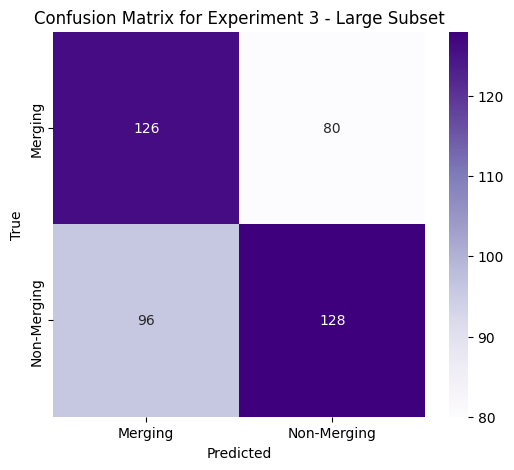

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


print(classification_report(all_labels, all_preds, target_names=["Merging", "Non-Merging"]))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Merging", "Non-Merging"],
            yticklabels=["Merging", "Non-Merging"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Experiment 3 - Large Subset')
plt.show()


In [ ]:
# Predict Redshift
true_redshifts = []
pred_redshifts = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        redshifts = batch['redshift'].to(device)

        _, redshift_out = model(images)

        true_redshifts.append(redshifts.cpu().numpy())
        pred_redshifts.append(redshift_out.cpu().numpy())

true_redshifts = np.concatenate(true_redshifts)
pred_redshifts = np.concatenate(pred_redshifts)

# Regression Metrics
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(true_redshifts, pred_redshifts)
r2 = r2_score(true_redshifts, pred_redshifts)

print(f"Redshift MSE: {mse:.6f}")
print(f"Redshift R^2: {r2:.4f}")
print(true_redshifts[:10])
print(pred_redshifts[:10])

Redshift MSE: 0.007964
Redshift R^2: -4.1254
[0.09919374 0.06126079 0.05541958 0.11103552 0.14276846 0.12813514
 0.073213   0.10315268 0.02978732 0.0539353 ]
[-0.02363398  0.0554497   0.06478224  0.07193352  0.05106095  0.04655632
  0.07941294  0.09087504 -0.0181591   0.04029837]


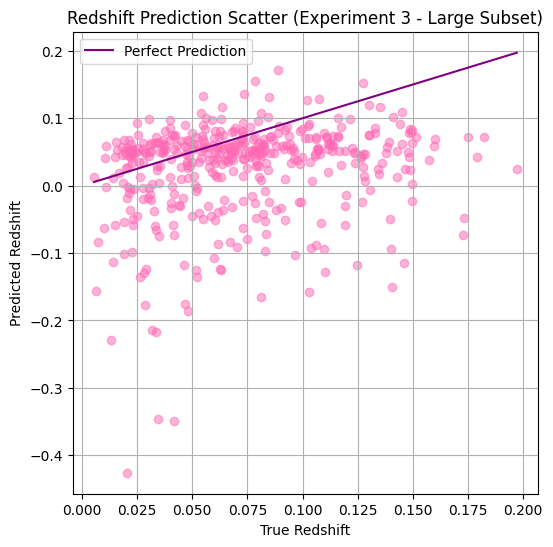

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(true_redshifts, pred_redshifts, color = 'hotpink', alpha=0.5)
plt.plot([true_redshifts.min(), true_redshifts.max()],
         [true_redshifts.min(), true_redshifts.max()],
         'purple', label='Perfect Prediction')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Prediction Scatter (Experiment 3 - Large Subset)')
plt.legend()
plt.grid(True)
plt.show()


Develop CNN further as accuracy is still low

In [ ]:
# Augment for grayscale

import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),  # Random zoom-in (crop and resize)
    transforms.RandomHorizontalFlip(),                    # Random horizontal flip
    transforms.RandomVerticalFlip(),                      # Random vertical flip
    transforms.RandomRotation(degrees=30),                # Random small rotations
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Random translations (move galaxy slightly)
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x)  # No augmentation on validation
])


### CNN version 2

**Goal:** Improve model generalisation/classification accuracy by using a deeper CNN with additional convolutional layers, batch normalisation, and slightly higher dropout.

- 4 conv layers (instead of 3)
- Batch normalisation after each conv block
- Increased depth in features
- Larger fully connected layers
- Stronger dropout 0.4
- Early stopping to prevent overfitting

In [ ]:
class DualHeadCNNv2(nn.Module):
    def __init__(self):
        super(DualHeadCNNv2, self).__init__()
        '''
4 conv layers,  batchnorm after every conv layer, larger feature depth (up to 256),
larger fully connected, droppout p = 0.4
        '''

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # New layer
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.flatten = nn.Flatten()

        self.shared_fc = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),  # Adjust dimension
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
        )

        self.classifier = nn.Linear(128, 2)
        self.regressor = nn.Linear(128, 1)

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        x = self.shared_fc(x)

        class_out = self.classifier(x)
        redshift_out = self.regressor(x).squeeze(1)

        return class_out, redshift_out

split earlier and add to each split. less shared layers
change rgb to grayscale

In [ ]:
from torch.utils.data import DataLoader

train_dataset = MergerDataset(train_images, train_labels, train_redshifts, transform=train_transform)
val_dataset = MergerDataset(val_images, val_labels, val_redshifts, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch.nn as nn

class DualHeadCNNv2(nn.Module):
    def __init__(self):
        super(DualHeadCNNv2, self).__init__()

        # Shared feature extractor (Convs only)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Flatten before heads
        self.flatten = nn.Flatten()


        # Classification head
        self.classifier_fc = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

        # Regression head
        self.regressor_fc = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)

        class_out = self.classifier_fc(x)
        redshift_out = self.regressor_fc(x).squeeze(1)

        return class_out, redshift_out


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualHeadCNNv2().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
train_acc, val_acc, train_class_loss, val_class_loss, train_reg_loss, val_reg_loss = train_and_validate_with_early_stopping(
    model, train_loader, val_loader, optimiser,
    num_epochs=100, alpha=8.0, beta=4.0, patience=15
)

Saved new best model at epoch 1 with val accuracy 52.09%
Epoch 1/100 | Train Acc: 48.31% | Val Acc: 52.09%
Epoch 2/100 | Train Acc: 50.70% | Val Acc: 51.86%
Saved new best model at epoch 3 with val accuracy 53.26%
Epoch 3/100 | Train Acc: 52.91% | Val Acc: 53.26%
Saved new best model at epoch 4 with val accuracy 57.21%
Epoch 4/100 | Train Acc: 56.06% | Val Acc: 57.21%
Epoch 5/100 | Train Acc: 57.46% | Val Acc: 50.47%
Epoch 6/100 | Train Acc: 57.05% | Val Acc: 55.81%
Saved new best model at epoch 7 with val accuracy 59.07%
Epoch 7/100 | Train Acc: 59.21% | Val Acc: 59.07%
Epoch 8/100 | Train Acc: 59.32% | Val Acc: 56.51%
Epoch 9/100 | Train Acc: 61.89% | Val Acc: 56.98%
Saved new best model at epoch 10 with val accuracy 59.53%
Epoch 10/100 | Train Acc: 62.30% | Val Acc: 59.53%
Saved new best model at epoch 11 with val accuracy 60.47%
Epoch 11/100 | Train Acc: 62.70% | Val Acc: 60.47%
Epoch 12/100 | Train Acc: 64.80% | Val Acc: 56.51%
Epoch 13/100 | Train Acc: 64.34% | Val Acc: 56.98%
Ep

              precision    recall  f1-score   support

     Merging       0.62      0.61      0.61       206
 Non-Merging       0.64      0.66      0.65       224

    accuracy                           0.63       430
   macro avg       0.63      0.63      0.63       430
weighted avg       0.63      0.63      0.63       430



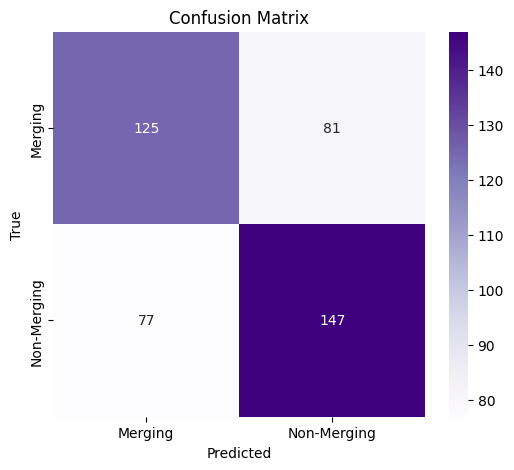

In [ ]:
model = DualHeadCNNv2().to(device)

# Load best saved weights
model.load_state_dict(torch.load("best_dualhead_model_exp4.pth"))
model.eval()

# Predict on validation set
all_labels = []
all_preds = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)

        class_out, _ = model(images)
        preds = class_out.argmax(dim=1)

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, target_names=["Merging", "Non-Merging"]))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=["Merging", "Non-Merging"], yticklabels=["Merging", "Non-Merging"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Predict redshift on validation set
true_redshifts = []
pred_redshifts = []

model.eval()
with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].to(device)
        labels = batch['label'].to(device)  # not used here
        redshifts = batch['redshift'].to(device)

        _, redshift_out = model(images)  # get regression output
        true_redshifts.append(redshifts.cpu().numpy())
        pred_redshifts.append(redshift_out.cpu().numpy())

# Flatten arrays
true_redshifts = np.concatenate(true_redshifts)
pred_redshifts = np.concatenate(pred_redshifts)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

mse_v2 = mean_squared_error(true_redshifts, pred_redshifts)
r2_v2 = r2_score(true_redshifts, pred_redshifts)

print(f"Experiment 4 - Redshift MSE: {mse_v2:.6f}")
print(f"Experiment 4 - Redshift R²: {r2_v2:.4f}")


Experiment 4 - Redshift MSE: 0.001804
Experiment 4 - Redshift R²: -0.1608


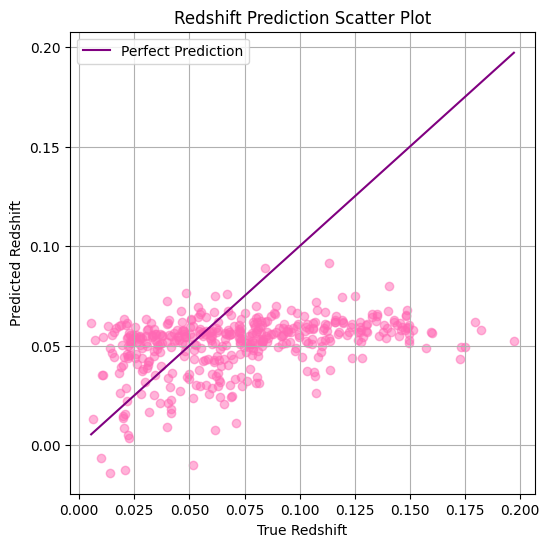

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(true_redshifts, pred_redshifts, color = 'hotpink', alpha=0.5)
plt.plot([true_redshifts.min(), true_redshifts.max()],
         [true_redshifts.min(), true_redshifts.max()],
         'purple', label='Perfect Prediction')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Redshift Prediction Scatter Plot')
plt.legend()
plt.grid(True)
plt.show()


### CNN Version 3


In [ ]:
import torch.nn as nn

class SimplerDualHeadCNN(nn.Module):
    def __init__(self):
        super(SimplerDualHeadCNN, self).__init__()

        # Shared Convolutional Feature Extractor (simpler)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Flatten output
        self.flatten = nn.Flatten()

        # Classification head
        self.classifier_fc = nn.Sequential(
            nn.Linear(64 * 64 * 64, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 2)
        )

        # Regression head
        self.regressor_fc = nn.Sequential(
            nn.Linear(64 * 64 * 64, 256),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)

        class_out = self.classifier_fc(x)
        redshift_out = self.regressor_fc(x).squeeze(1)

        return class_out, redshift_out


In [ ]:
# 4. Stronger Grayscale Augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=30),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x)
])


In [ ]:
# 5. Load Grayscale Dataset
data = np.load('/content/drive/MyDrive/norm_merger_balanced_large_subset_grayscale.npz')
images = data['images']
labels = data['labels']
redshifts = data['redshifts']

In [ ]:
# 6. Train/Val Split
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels, train_redshifts, val_redshifts = train_test_split(
    images, labels, redshifts, test_size=0.2, random_state=42)

# 7. Create Datasets + Dataloaders
train_dataset = MergerDataset(train_images, train_labels, train_redshifts, transform=train_transform)
val_dataset = MergerDataset(val_images, val_labels, val_redshifts, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# 8. Initialize Model and Optimizer
model = SimplerDualHeadCNN().to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=5e-4)

In [ ]:

# 9. Train the model using early stopping
train_acc, val_acc, train_class_loss, val_class_loss, train_reg_loss, val_reg_loss = train_and_validate_with_early_stopping(
    model, train_loader, val_loader, optimiser,
    num_epochs=100, alpha=10.0, beta=1.0, patience=10
)

Saved new best model at epoch 1 with val accuracy 53.26%
Epoch 1/100 | Train Acc: 47.79% | Val Acc: 53.26%
Epoch 2/100 | Train Acc: 50.06% | Val Acc: 52.09%
Epoch 3/100 | Train Acc: 49.94% | Val Acc: 48.37%
Epoch 4/100 | Train Acc: 50.76% | Val Acc: 47.44%
Epoch 5/100 | Train Acc: 50.52% | Val Acc: 47.91%
Epoch 6/100 | Train Acc: 50.41% | Val Acc: 47.91%
Epoch 7/100 | Train Acc: 51.40% | Val Acc: 47.21%
Epoch 8/100 | Train Acc: 52.51% | Val Acc: 49.07%
Saved new best model at epoch 9 with val accuracy 56.28%
Epoch 9/100 | Train Acc: 52.56% | Val Acc: 56.28%
Epoch 10/100 | Train Acc: 52.62% | Val Acc: 56.05%
Saved new best model at epoch 11 with val accuracy 57.21%
Epoch 11/100 | Train Acc: 51.69% | Val Acc: 57.21%
Epoch 12/100 | Train Acc: 55.30% | Val Acc: 56.05%
Epoch 13/100 | Train Acc: 53.38% | Val Acc: 55.12%
Epoch 14/100 | Train Acc: 53.09% | Val Acc: 54.65%
Epoch 15/100 | Train Acc: 55.24% | Val Acc: 56.05%
Epoch 16/100 | Train Acc: 53.96% | Val Acc: 55.12%
Epoch 17/100 | Train 

### Just focusing on classification

In [ ]:
class DualHeadCNNv2(nn.Module):
    def __init__(self):
        super(DualHeadCNNv2, self).__init__()

        # Shared feature extractor (Convs only)
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Flatten before heads
        self.flatten = nn.Flatten()



        # Classification head
        self.classifier_fc = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

        # Regression head
        self.regressor_fc = nn.Sequential(
            nn.Linear(256 * 16 * 16, 512),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        class_out = self.classifier_fc(x)
        return class_out



In [ ]:
def train_and_validate_classification_only(model, train_loader, val_loader, optimiser, num_epochs=100, patience=15):
    criterion = nn.CrossEntropyLoss()
    device = next(model.parameters()).device

    best_val_loss = float('inf')
    patience_counter = 0

    train_acc_list = []
    val_acc_list = []
    train_loss_list = []
    val_loss_list = []

    for epoch in range(num_epochs):
        model.train()
        correct = 0
        total = 0
        running_loss = 0

        for batch in train_loader:
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)

            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_acc = correct / total
        train_acc_list.append(train_acc)
        train_loss_list.append(train_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        running_loss = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs = batch['image'].to(device)
                labels = batch['label'].to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = running_loss / len(val_loader.dataset)
        val_acc = correct / total
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)

        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list


In [ ]:
model = DualHeadCNNv2().to(device)
criterion = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-3)


In [ ]:
train_acc, val_acc, train_loss, val_loss = train_and_validate_classification_only(
    model, train_loader, val_loader, optimiser,
    num_epochs=100, patience=15
)


Epoch 1: Train Acc: 0.5111, Val Acc: 0.4837
Epoch 2: Train Acc: 0.5379, Val Acc: 0.4907
Epoch 3: Train Acc: 0.5874, Val Acc: 0.5698
Epoch 4: Train Acc: 0.5915, Val Acc: 0.5791
Epoch 5: Train Acc: 0.5985, Val Acc: 0.5628
Epoch 6: Train Acc: 0.6317, Val Acc: 0.6256
Epoch 7: Train Acc: 0.6387, Val Acc: 0.5977
Epoch 8: Train Acc: 0.6550, Val Acc: 0.6186
Epoch 9: Train Acc: 0.6585, Val Acc: 0.6140
Epoch 10: Train Acc: 0.6638, Val Acc: 0.6047
Epoch 11: Train Acc: 0.6783, Val Acc: 0.6140
Epoch 12: Train Acc: 0.6725, Val Acc: 0.5070
Epoch 13: Train Acc: 0.6993, Val Acc: 0.6163
Epoch 14: Train Acc: 0.6970, Val Acc: 0.6116
Epoch 15: Train Acc: 0.7348, Val Acc: 0.6116
Epoch 16: Train Acc: 0.7424, Val Acc: 0.6163
Epoch 17: Train Acc: 0.7617, Val Acc: 0.6256
Epoch 18: Train Acc: 0.7739, Val Acc: 0.6070
Epoch 19: Train Acc: 0.7855, Val Acc: 0.6395
Epoch 20: Train Acc: 0.7972, Val Acc: 0.6256
Epoch 21: Train Acc: 0.8199, Val Acc: 0.6372
Epoch 22: Train Acc: 0.8298, Val Acc: 0.5814
Epoch 23: Train Acc

### Model 5: Deeper model

In [ ]:
import torch
import torch.nn as nn

class DualHeadCNNv3(nn.Module):
    def __init__(self):
        super(DualHeadCNNv3, self).__init__()

        # Stronger feature extractor
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 256 -> 128

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))  # output shape (batch, 512, 1, 1)
        )

        self.flatten = nn.Flatten()

        # Classification head
        self.classifier_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 2)
        )

        # Regression head (optional for later)
        self.regressor_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        class_out = self.classifier_fc(x)
        # redshift_out = self.regressor_fc(x).squeeze(1)  # Save for later
        return class_out


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [ ]:
model = DualHeadCNNv3().to(device)

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=5, verbose=True)



In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualHeadCNNv3().to(device)


optimiser = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=5, verbose=True)

criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


num_epochs = 100
patience = 15

best_val_loss = float('inf')
patience_counter = 0

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation phase
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Print epoch
    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, LR: {optimiser.param_groups[0]['lr']:.6f}")

    # Step the scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_v3.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
print("Training finished.")


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Acc: 0.5606, Val Acc: 0.5837, LR: 0.000100
Epoch 2: Train Acc: 0.6119, Val Acc: 0.6419, LR: 0.000100
Epoch 3: Train Acc: 0.6317, Val Acc: 0.6558, LR: 0.000100
Epoch 4: Train Acc: 0.6323, Val Acc: 0.6442, LR: 0.000100
Epoch 5: Train Acc: 0.6422, Val Acc: 0.5047, LR: 0.000100
Epoch 6: Train Acc: 0.6486, Val Acc: 0.6721, LR: 0.000100
Epoch 7: Train Acc: 0.6445, Val Acc: 0.6349, LR: 0.000100
Epoch 8: Train Acc: 0.6632, Val Acc: 0.6628, LR: 0.000100
Epoch 9: Train Acc: 0.6696, Val Acc: 0.6674, LR: 0.000100
Epoch 10: Train Acc: 0.6585, Val Acc: 0.6512, LR: 0.000100
Epoch 11: Train Acc: 0.6690, Val Acc: 0.5488, LR: 0.000100
Epoch 12: Train Acc: 0.6684, Val Acc: 0.6186, LR: 0.000100
Epoch 13: Train Acc: 0.6876, Val Acc: 0.6744, LR: 0.000100
Epoch 14: Train Acc: 0.7040, Val Acc: 0.7070, LR: 0.000100
Epoch 15: Train Acc: 0.6882, Val Acc: 0.6884, LR: 0.000100
Epoch 16: Train Acc: 0.7127, Val Acc: 0.5977, LR: 0.000100
Epoch 17: Train Acc: 0.7197, Val Acc: 0.5279, LR: 0.000100
Epoch 

Add more regularisation and weight decay

In [ ]:


# Updated Stronger Augmentation

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.02),
    #transforms.ColorJitter(brightness=0.3, contrast=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
])

val_transform = transforms.Compose([
    transforms.Lambda(lambda x: x)  # No transform for validation
])

#DualHeadCNNv3 with Dropout 0.6

class DualHeadCNNv3(nn.Module):
    def __init__(self):
        super(DualHeadCNNv3, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()
        self.classifier_fc = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.flatten(x)
        class_out = self.classifier_fc(x)
        return class_out



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DualHeadCNNv3().to(device)

optimiser = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)

scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=5, verbose=True)
criterion = nn.CrossEntropyLoss()


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


num_epochs = 100
patience = 10

best_val_loss = float('inf')
patience_counter = 0

train_acc_list = []
val_acc_list = []
train_loss_list = []
val_loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for batch in train_loader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimiser.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimiser.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    # Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = running_loss / len(val_loader.dataset)
    val_acc = correct / total
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    # Print Epoch Info
    print(f"Epoch {epoch+1}: Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, LR: {optimiser.param_groups[0]['lr']:.6f}")

    # Step scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model_v3.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

print("Training finished.")



/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Acc: 0.5600, Val Acc: 0.5279, LR: 0.000050
Epoch 2: Train Acc: 0.5857, Val Acc: 0.6488, LR: 0.000050
Epoch 3: Train Acc: 0.6189, Val Acc: 0.6465, LR: 0.000050
Epoch 4: Train Acc: 0.6247, Val Acc: 0.5605, LR: 0.000050
Epoch 5: Train Acc: 0.6404, Val Acc: 0.6326, LR: 0.000050
Epoch 6: Train Acc: 0.6375, Val Acc: 0.6116, LR: 0.000050
Epoch 7: Train Acc: 0.6533, Val Acc: 0.6023, LR: 0.000050
Epoch 8: Train Acc: 0.6591, Val Acc: 0.6465, LR: 0.000050
Epoch 9: Train Acc: 0.6620, Val Acc: 0.6256, LR: 0.000050
Epoch 10: Train Acc: 0.6900, Val Acc: 0.6512, LR: 0.000025
Epoch 11: Train Acc: 0.6917, Val Acc: 0.6581, LR: 0.000025
Epoch 12: Train Acc: 0.6970, Val Acc: 0.6465, LR: 0.000025
Epoch 13: Train Acc: 0.7127, Val Acc: 0.6209, LR: 0.000025
Epoch 14: Train Acc: 0.7174, Val Acc: 0.5442, LR: 0.000025
Epoch 15: Train Acc: 0.7290, Val Acc: 0.6465, LR: 0.000025
Epoch 16: Train Acc: 0.7570, Val Acc: 0.5279, LR: 0.000025
Epoch 17: Train Acc: 0.7885, Val Acc: 0.5349, LR: 0.000013
Epoch 

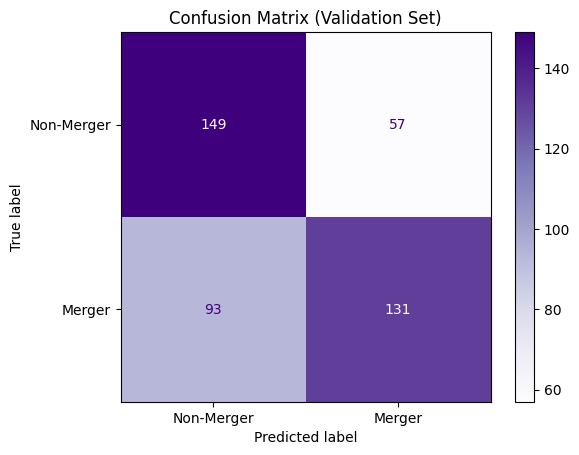

              precision    recall  f1-score   support

     Merging       0.62      0.72      0.67       206
 Non-Merging       0.70      0.58      0.64       224

    accuracy                           0.65       430
   macro avg       0.66      0.65      0.65       430
weighted avg       0.66      0.65      0.65       430



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Load model
model.load_state_dict(torch.load('best_model_v3.pth'))
model.eval()

# Get all validation predictions
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Merger", "Merger"])
disp.plot(cmap='Purples')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_labels, all_preds, target_names=["Merging", "Non-Merging"]))

